This code uses Recurrent Neural Network with Long-Short-Term Memory units.<br>
We perform 70/30 train/test split on the data. Fit the model on the train data and then predict the outcome for all the test observations at once.<br>
The breakpoint detection is only done once for the whole dataset.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import json
import tensorflow as tf

In [2]:
def smape(predictions, actual):
    difference = np.abs(predictions-actual)
    summation = np.abs(actual)+np.abs(predictions)
    error = np.mean(difference/summation)
    return error

In [3]:
def fit_lstm(train):
    # reshape training into [samples, timesteps, features]
    X, y = train.iloc[:, 1:], train.iloc[:, 0]
    
    #cannot reshape datafame
    X_arrays = np.asarray(X)
    X = np.hstack(X_arrays).reshape(X.shape[0], 1, X.shape[1])

    #build model
    model = Sequential()
    model.add(LSTM(4, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
    
    # fit network
    model.fit(X, y, epochs = 1000, batch_size = 100, verbose = 0, callbacks=[es], shuffle = False)
    
    return model

In [4]:
def preprocessing(data):
    n = len(data)
    
    #transforming concept and transition columns
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    
    #scaling
    scaler_x = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t-1":"t-5"] = scaler_x.fit_transform(data.loc[:,"t-1":"t-5"])
    
    #need separate scaler only for target
    scaler_y = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t"] = scaler_y.fit_transform(np.asarray(data.loc[:,"t"]).reshape([-1,1]))
    
    #train/test split
    train, test = data[:int(0.7*n)], data[int(0.7*n):]    
    
    return train, test, scaler_y

In [5]:
list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
                "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt",
                "linear1_inc", "linear2_inc", "linear3_inc",
                "nonlinear1_inc", "nonlinear2_inc", "nonlinear3_inc"]

Time wasted: 24.03s
0.3687300838295651


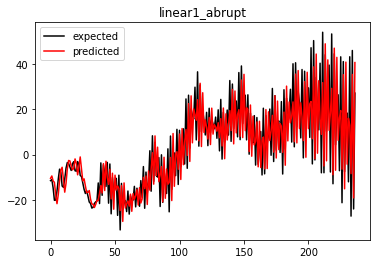

Time wasted: 35.39s
0.028093154278024144


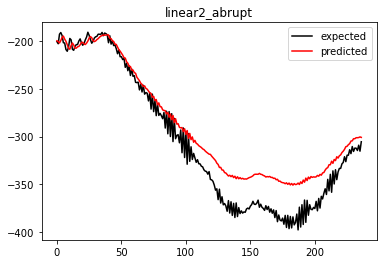

Time wasted: 32.34s
0.10802511716161166


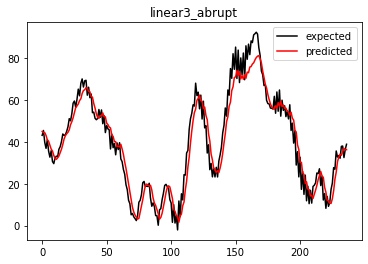

Time wasted: 26.44s
0.6374059781891611


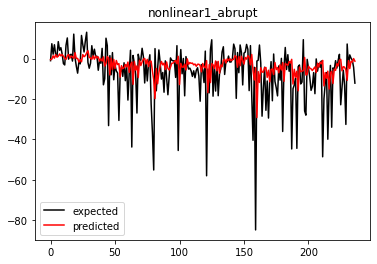

Time wasted: 25.99s
0.016535724705090626


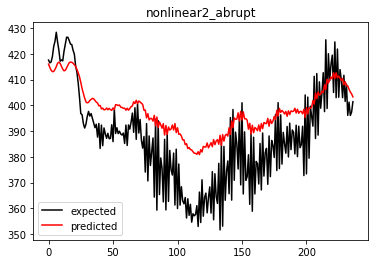

Time wasted: 26.71s
0.31355644763158047


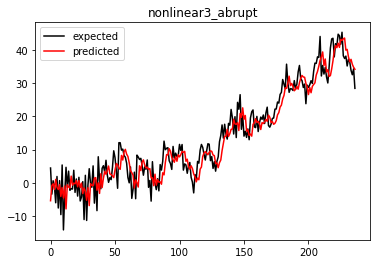

Time wasted: 28.52s
0.42166835585000534


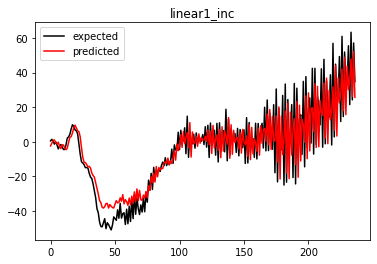

Time wasted: 32.80s
0.025057886281116097


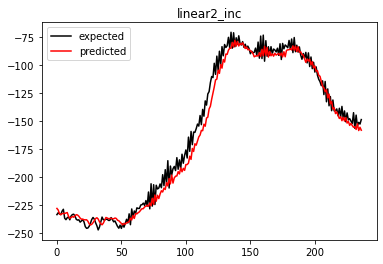

Time wasted: 29.28s
0.17500625448818147


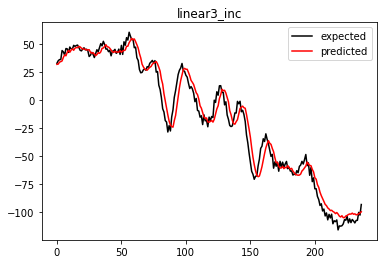

Time wasted: 29.80s
0.7470145600278131


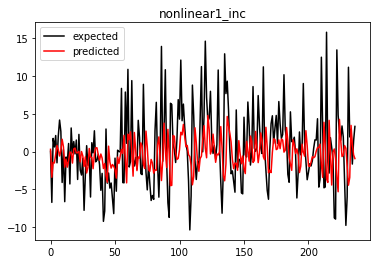

Time wasted: 28.43s
0.12822077950588645


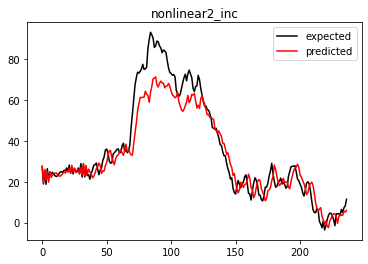

Time wasted: 30.80s
0.5879670596862991


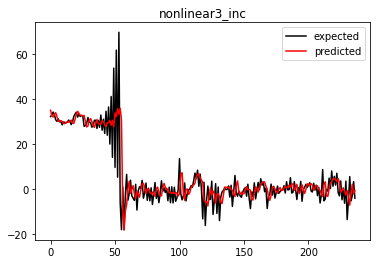

In [6]:
smape_dict_without = {}

for name in list_of_names:
    #loading the data
    file_path = "data/"+name
    data = pd.read_csv(file_path)
    
    #need this for error computation and plotting
    ground_truth = data.loc[int(0.7*len(data)):, "t"]
    
    #simple preprocessing
    train, test, scaler = preprocessing(data)
    
    #need to reshape test data
    X = test.loc[:,"t-1":"t-5"]
    X_arrays = np.asarray(X)
    test_X = np.hstack(X_arrays).reshape(X.shape[0], 1, X.shape[1])
    
    #fitting and plotting with concept
    start = time.perf_counter()
    model = fit_lstm(train.loc[:,"t":"t-5"])
    
    #if you just pass test_X to model.predict() it only returns 8 values???
    predictions = []
    for i in range(len(test_X)):
        prediction = model.predict(test_X[i,:,:].reshape(1,1,5))[0]
        predictions.append(prediction)
    end = time.perf_counter()
    print("Time wasted: {:.2f}s".format((end-start)))
    
    #need to get predictions to original scale
    predictions = scaler.inverse_transform(np.asarray(predictions).reshape([-1,1]))
    
    error = smape(predictions, ground_truth.reset_index(drop = True).values.reshape([-1,1]))
    smape_dict_without[name] = error
    
    print(error)
    plt.plot(ground_truth.reset_index(drop = True), label = "expected", color = "black")
    plt.plot(predictions, label = "predicted", color = "red")
    plt.legend()
    plt.title(name)
    
    #saving the plots
    image_path = "forecasting_results/lstm/"+name+".png"
    plt.savefig(image_path)
    
    plt.show()
    
dict_path = "forecasting_results/lstm/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict_without))